<a href="https://colab.research.google.com/github/pachterlab/monod/blob/anndata/Monod_demo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Monod* on Colab

In the current notebook, we apply *Monod* to identify differentially regulated genes between GABAergic and glutamatergic cell types in a single Allen dataset.

# Inference pipeline

## Import prerequisites

In [1]:
!pip install scanpy

In [5]:
!pip install loompy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 65.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.6 MB/s eta 0:00:00
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52019 sha256=ac2ad9da9eb5409ae70f910f682af531ea72388a4c7bdd43ea0f29ccfbfbd66d
  Stored in directory: /root/.cache/pip/wheels/2c/22/1f/792a4621bb631e538bf1c21feae9bbaa6b19fd6d6ab382d1fd
Successfully built loompy


## Install monod

In [1]:
!git clone -b anndata --single-branch https://github.com/pachterlab/monod.git

Cloning into 'monod'...
remote: Enumerating objects: 1097, done.
remote: Counting objects: 100% (526/526), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 1097 (delta 424), reused 404 (delta 354), pack-reused 571 (from 1)
Receiving objects: 100% (1097/1097), 22.34 MiB | 9.19 MiB/s, done.
Resolving deltas: 100% (635/635), done.
Updating files: 100% (32/32), done.


Let's make sure that the version is correct.

In [1]:
import sys
# sys.path.insert(0, 'monod/src/monod')
sys.path.insert(0, 'src/monod')


import extract_data, cme_toolbox, inference, analysis, mminference

used


## Import data

In [7]:
! git clone https://github.com/pachterlab/monod_examples.git

Cloning into 'monod_examples'...
remote: Enumerating objects: 1492, done.
remote: Counting objects: 100% (433/433), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 1492 (delta 192), reused 399 (delta 181), pack-reused 1059 (from 1)
Receiving objects: 100% (1492/1492), 1.07 GiB | 23.52 MiB/s, done.
Resolving deltas: 100% (536/536), done.
Updating files: 100% (92/92), done.


## Import other packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import anndata
from IPython.display import display, Markdown
import scanpy as sc
import random

In [3]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')

## Knee plot and filter.

/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


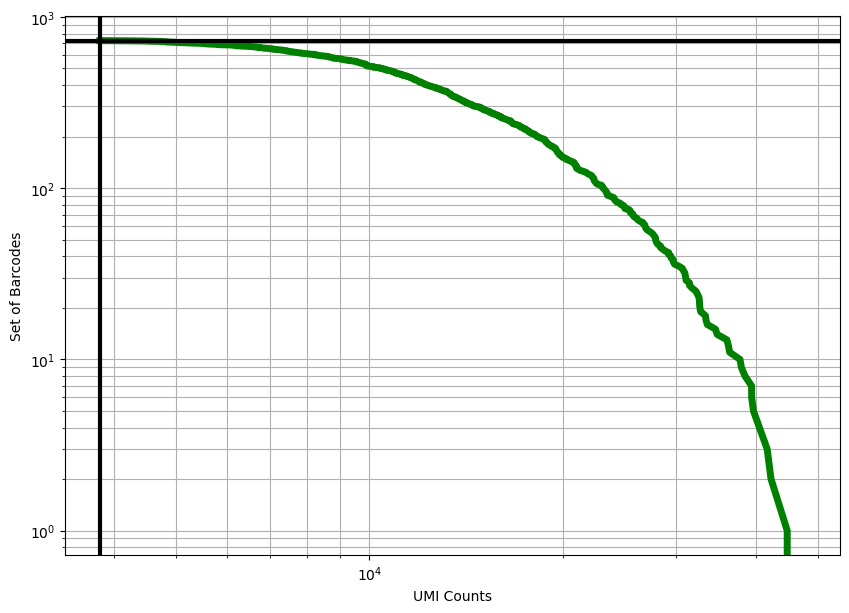

In [19]:
# Load anndata.
gaba_adata = anndata.read_h5ad('./gaba_example.h5ad')
gaba_adata.var_names_make_unique()

# Create knee plot. (Example data is already filtered, but adjust for other data.)
expected_num_cells =  727 # @param {type:"integer"}
knee = np.sort((np.array(gaba_adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

sc.pp.filter_cells(gaba_adata, min_genes=100)
# sc.pp.filter_genes(gaba_adata, min_cells=3)

In [21]:
## Optionally for meK-means, filter for highly variable genes. Taken from meK-Means example notebook.

S = gaba_adata.layers['spliced'][:,:].toarray()
U = gaba_adata.layers['unspliced'][:,:].toarray()
g_names = gaba_adata.var_names

def nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02):
    '''
    Take in U,S matrices, and find genes that meet var/mean thresh
    U,S: cellxgene count matrices
    var_t: dispersion threshold
    u_min: minumum U average count
    s_min: minumum S average count
    '''
    var_threshold = var_t
    U_mean = U.mean(0)
    S_mean = S.mean(0)
    U_var = U.var(0)
    S_var = S.var(0)

    u_min = u_min
    s_min =  s_min

    fitted_idx = (U_mean > u_min) & (S_mean > s_min) \
    & (((U_var-U_mean)/(U_mean**2)) > var_threshold)\
    & (((S_var-S_mean)/(S_mean**2)) > var_threshold)\
    & (np.abs(np.log(S_mean/U_mean)) < 4)

    return fitted_idx

## Note that the anndata matrices are cellxgene, in contrast to meK-Means example.
#Filter for genes that pass thresholds
fitted_idx = nb_thresh(U,S,var_t = 1.5,u_min =0.02,s_min =0.02)
print('No. all genes that pass thresh: ', np.sum(fitted_idx))

#Get HVGs by standard methods
X=S  #May be better to use U.T for nuclear, snRNAseq, data
adata = anndata.AnnData(X=X)
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

g_names_toUse = g_names[fitted_idx & adata.var.highly_variable]
print('No. of genes in 2k HVGs that pass filter: ',len(g_names_toUse))

No. all genes that pass thresh:  1512
No. of genes in 2k HVGs that pass filter:  668


## Set up model and perform inference.

In [35]:
import importlib

importlib.reload(cme_toolbox)
importlib.reload(analysis)
importlib.reload(mminference)
importlib.reload(extract_data)
importlib.reload(inference)


<module 'inference' from '/home/cat/monod/src/monod/inference.py'>

In [20]:
# Define model.
fitmodel = cme_toolbox.CMEModel('Bursty','Poisson')
transcriptome_filepath = './monod_examples/polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

n_genes = 100
demo_genes = ['Eif5b','Xrcc5',	'Klhl12','Rgs7','Thsd7b']
all_DE = ['Rcan3', 'Rspo3', 'Vrk1', 'Tcerg1l', 'Clic4', 'Hcrtr2', '1110004F10Rik', 'Erbin', 'Lrp12', 'Gatm', 'Rims3']
# hv_genes = random.sample(list(g_names_toUse), n_genes)

# Perform inference. (don't need to give these bounds, here for debugging but can use defaults.)
lb = [-1.0, -1.8, -1.8 ]
ub = [4.2, 2.5, 3.5]
# samp_lb, samp_ub = [-8, -3],[-5, 0]
# grid = [6,7]

## Fix sampling parameters to the ones given in the other Monod example.
samp_lb, samp_ub = [-6.8, -1.5],[-6.9, -1.6]
grid = [1,1]

# TODO: make 'nascent', 'mature' automatically recognized.
# './gaba_example.h5ad'
mek_means_params = (4,2) # Set to none if not using meK-Means

# TODO: fix number of genes selected (no longer getting to total every time).
gaba_adata = inference.perform_inference(gaba_adata, fitmodel, n_genes=n_genes, seed=5, genes_to_fit=demo_genes,
            phys_lb=lb, phys_ub=ub, gridsize=grid, samp_lb=samp_lb, samp_ub=samp_ub,
            gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1},
                                         transcriptome_filepath=transcriptome_filepath, poisson_average_log_length=5, dataset_string='new_gaba__', viz=False,
                                         num_cores=8, mek_means_params=mek_means_params)

The expected modalities for this model are: ['unspliced', 'spliced']
If your anndata layers have different names, please give a modality dictionary of the form: modality_name_dict  = {'spliced':your_spliced_layer_name, 'unspliced':your_unspliced_layer_name} 
INFO:root:Directory new_gaba__ already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: new_gaba__
is sparse
INFO:root:Added lengths


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


INFO:root:728 cells detected.
3578 genes retained after expression filter.
INFO:root:95 random genes selected.
INFO:root:Total of 100 genes selected.
['unspliced', 'spliced'] previous ordering
['unspliced', 'spliced'] ordered for histogram
INFO:root:Data extracted
LayersView with keys: unspliced, spliced
['unspliced', 'spliced']
INFO:root:Search data created.
INFO:root:Directory new_gaba__/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to new_gaba__/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


/home/cat/.conda/envs/myenv/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=264095) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.17it/s]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/2: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.36301189 0.23973387 0.15684419 0.24041005]
Q Function:  -232928.48114785654

INFO:root:EM Epoch 2/2: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|█████████████████████████████████████████████| 4/4 [00:03<00:00,  1.09it/s]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.38534626 0.220229   0.16916182 0.22526293]
Q Function:  -229843.93718884166

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory new_gaba__/Bursty_Poisson_1x1/analysis_figures_0 already exists.
INFO:root:Directory new_gaba__/Bursty_Poisson_1x1/analysis_figures_1 already exists.
INFO:root:Directory new_gaba__/Bursty_Poisson_1x1/analysis_figures_2 already exists.
INFO:root:Directory new_gaba__/Bursty_Poisson_1x1/analysis_figures_3 already exists.
INFO:root:Runtime: 12.5 seconds.
INFO:root:Grid points fit.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters for each cluster saved to anndata. For cluster i, the .var attribute is of the form: "ci_$\gamma$". Note that the parameters are given in log-base 10.



/home/cat/monod/src/monod/inference.py:175: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  monod_adata.var["c{}_".format(j) + without_log] = param_values


INFO:root:AIC values calculated and saved under .var attribute: AIC.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Gene 52 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 81 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 21.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.


/home/cat/monod/src/monod/mminference.py:2144: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Gene 92 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 23.9 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.


/home/cat/monod/src/monod/mminference.py:2144: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Gene 52 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 72 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Gene 87 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 23.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.


/home/cat/monod/src/monod/mminference.py:2144: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Gene 52 gives negative stdev; replaced with mean. (Search converged to local minimum?)
INFO:root:Standard error of the MLE computation complete. Runtime: 27.6 seconds.
INFO:root:Uncertainties per gene calculated for each cluster. E.g. for cluser, i, uncertainty saved to anndata in .var attribute of the form: "ci_error_$\gamma$". Note that the errors are given in log-base 10.
INFO:root:Saving clusters
INFO:root:Cluster labels added to anndata .obs


/home/cat/monod/src/monod/mminference.py:2144: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Directory glu_example already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: glu_example
INFO:root:Duplicate variable names found. Making them unique...
is sparse
INFO:root:Added lengths


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


INFO:root:6629 cells detected.
5520 genes retained after expression filter.
INFO:root:0 random genes selected.
INFO:root:Total of 100 genes selected.
['unspliced', 'spliced'] previous ordering
['unspliced', 'spliced'] ordered for histogram
INFO:root:Data extracted
LayersView with keys: unspliced, spliced
['unspliced', 'spliced']
INFO:root:Search data created.
INFO:root:Directory glu_example/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to glu_example/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:EM Epoch 1/2: 
mstep self.weights:  [0.36046536 0.19358565 0.27805396 0.16789504]
Q Function:  -2125855.4637239883

INFO:root:EM Epoch 2/2: 
mstep self.weights:  [0.38779518 0.17973735 0.26214012 0.17032735]
Q Function:  -2096341.9652680254

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory glu_example/Bursty_Poisson_1x1/analys

/home/cat/monod/src/monod/inference.py:175: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  monod_adata.var["c{}_".format(j) + without_log] = param_values


INFO:root:AIC values calculated and saved under .var attribute: AIC.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 42.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 33.2 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 56.4 seconds.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 35.4 seconds.
INFO:root:U

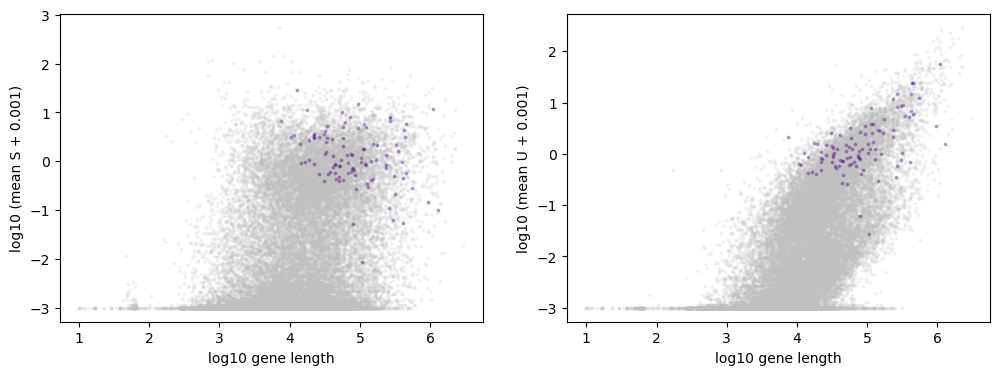

In [21]:
# Fix the genes to be the same as for the gaba data.
genes_to_fit = [i for i in gaba_adata.var_names]
n_genes = len(genes_to_fit)

glu_adata = inference.perform_inference('./glu_example.h5ad', fitmodel, n_genes=n_genes, seed=4, genes_to_fit=genes_to_fit,
                                       phys_lb=lb, phys_ub=ub, gridsize=grid, samp_lb=samp_lb, samp_ub=samp_ub,
                                        gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1},
                                       transcriptome_filepath=transcriptome_filepath, mek_means_params=mek_means_params) #['Eif5b', 'Thsd7b', 'Fbxw2', 'Otud7a', 'Asah1'])glu_adata = inference.perform_inference('./glu_example.h5ad', fitmodel, n_genes=5, seed=4, genes_to_fit=DE_genes,

In [ ]:
# # NB currently can't save whole object to file since some .uns attributes cannot be pickled.
# gaba_adata.write('gaba_fit.h5ad')
# gaba_adata.write('glu_fit.h5ad')

## Access gene info.

In [22]:
# AIC.
display(gaba_adata.var[['AIC']])

# Optimum biological parameters.
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if '$' in i and 'error' not in i]])

# Uncertainties from Hessian.
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'error' in i]])

if mek_means_params:
    display(gaba_adata.obs)

,AIC
gene_name,
AC149090.1,6142.713435
Map2,7657.132182
Eif5b,4803.448985
Xrcc5,2716.187512
Ptprn,6581.244910
...,...
Ptchd1,2490.896462
Akap17b,3421.776417
Kdm5c,4733.413478


,c0_$b$,c1_$b$,c2_$b$,c3_$b$,c0_$\beta$,c1_$\beta$,c2_$\beta$,c3_$\beta$,c0_$\gamma$,c1_$\gamma$,c2_$\gamma$,c3_$\gamma$
gene_name,,,,,,,,,,,,
AC149090.1,2.561142,2.677454,2.269485,2.821033,-0.442525,-0.656464,-0.953743,-0.589569,0.653594,0.313366,0.019283,0.446093
Map2,1.500849,1.743630,1.543324,1.713154,-0.579031,-0.463461,-0.858794,-0.690578,-0.546917,-0.504736,-0.721113,-0.719832
Eif5b,1.311847,1.585384,1.400187,1.503805,-0.370861,-0.465401,-0.674004,-0.521067,-0.441690,-0.540132,-0.564176,-0.706851
Xrcc5,1.263563,2.031466,1.620815,1.754156,-0.154214,-0.099589,0.082125,0.004597,0.707358,0.549841,0.887216,0.707288
Ptprn,2.158380,2.105861,2.435175,2.380719,-0.358786,-0.646734,-0.476577,-0.321963,-0.071213,-0.483596,-0.079929,-0.281673
...,...,...,...,...,...,...,...,...,...,...,...,...
Ptchd1,2.098242,2.192706,2.239239,2.196805,0.358823,-0.044917,0.266498,0.051218,1.687189,1.219879,1.603852,1.146294
Akap17b,1.722187,1.990565,2.066482,1.748057,-0.264397,-0.454990,-0.205579,-0.675632,0.774866,0.601029,0.936285,0.333180
Kdm5c,1.579357,1.801390,1.641059,2.076984,-0.697338,-0.767630,-0.869117,-0.527324,0.153235,0.111983,0.112405,0.359671


,c0_error_$b$,c0_error_$\beta$,c0_error_$\gamma$,c1_error_$b$,c1_error_$\beta$,c1_error_$\gamma$,c2_error_$b$,c2_error_$\beta$,c2_error_$\gamma$,c3_error_$b$,c3_error_$\beta$,c3_error_$\gamma$
gene_name,,,,,,,,,,,,
AC149090.1,0.075422,0.070606,0.075655,0.083011,0.079476,0.081499,0.139743,0.135015,0.138244,0.075098,0.071090,0.073410
Map2,0.063452,0.061813,0.064193,0.066188,0.063245,0.066846,0.087436,0.085729,0.088532,0.064169,0.062233,0.064793
Eif5b,0.124163,0.124160,0.123871,0.111151,0.111346,0.110847,0.169974,0.169366,0.169708,0.116443,0.118222,0.115614
Xrcc5,0.198739,0.193477,0.210276,0.084060,0.076271,0.087102,0.156664,0.147235,0.179947,0.120231,0.111046,0.128471
Ptprn,0.062374,0.059142,0.061447,0.076891,0.074796,0.075885,0.075354,0.070947,0.074172,0.064219,0.060805,0.061179
...,...,...,...,...,...,...,...,...,...,...,...,...
Ptchd1,0.116792,0.102504,0.143628,0.106195,0.096874,0.120107,0.141213,0.123001,0.169630,0.103738,0.092069,0.113306
Akap17b,0.142911,0.137709,0.149047,0.120712,0.116302,0.125124,0.139136,0.131275,0.148263,0.154691,0.152287,0.158496
Kdm5c,0.145009,0.142718,0.146154,0.137185,0.135173,0.138930,0.190456,0.187507,0.192288,0.094688,0.091212,0.096535


,n_genes,cluster
barcode,,
AAACCCAAGCTATCCA,2652,0
AAAGAACTCTACCACC,5653,2
AAAGGATAGGTCATAA,3518,0
AAAGGGCCATTGAAAG,5412,3
AAAGGGCTCGGCTGTG,6080,3
...,...,...
TTTCACACACGCTTAA,6574,3
TTTCAGTCAATAGTCC,4334,2
TTTCCTCAGACGACGT,4334,2


In [23]:
# AIC.
display(glu_adata.var[['AIC']])

# Optimum biological parameters.
display(glu_adata.var[[i for i in gaba_adata.var.keys() if '$' in i and 'error' not in i]])

# Uncertainties from Hessian.
display(glu_adata.var[[i for i in gaba_adata.var.keys() if 'error' in i]])

if mek_means_params:
    display(glu_adata.obs)

,AIC
gene_name,
AC149090.1,59179.334994
Map2,73059.729895
Eif5b,48205.185712
Xrcc5,20727.647191
Ptprn,62697.450336
...,...
Ptchd1,31919.068674
Akap17b,32921.939525
Kdm5c,44818.505333


,c0_$b$,c1_$b$,c2_$b$,c3_$b$,c0_$\beta$,c1_$\beta$,c2_$\beta$,c3_$\beta$,c0_$\gamma$,c1_$\gamma$,c2_$\gamma$,c3_$\gamma$
gene_name,,,,,,,,,,,,
AC149090.1,2.639272,2.726093,2.815760,2.918258,-0.401390,-0.494824,-0.596944,-0.450801,0.635623,0.381352,0.344441,0.420753
Map2,1.416057,1.726873,1.732144,1.649681,-0.632554,-0.678985,-0.680454,-0.722316,-0.753982,-0.746982,-0.725847,-0.834355
Eif5b,1.342882,1.461089,1.541487,1.519476,-0.391220,-0.570236,-0.561782,-0.552855,-0.664879,-0.773111,-0.768356,-0.833657
Xrcc5,1.219025,1.377046,1.568512,1.414936,-0.087402,-0.163855,-0.082238,-0.268212,0.507645,0.407907,0.510220,0.358647
Ptprn,2.000559,2.110273,2.445779,2.274748,-0.459249,-0.659952,-0.484520,-0.638799,-0.303054,-0.475413,-0.216795,-0.455392
...,...,...,...,...,...,...,...,...,...,...,...,...
Ptchd1,1.908553,2.152022,2.125992,2.087836,-0.100656,-0.226785,-0.218754,-0.291372,1.071856,0.969617,0.933504,0.839785
Akap17b,1.568894,1.806200,1.816673,1.757611,-0.503436,-0.506626,-0.674429,-0.647424,0.523617,0.510151,0.361274,0.375089
Kdm5c,1.724318,1.848913,1.853553,2.039528,-0.594555,-0.715110,-0.803666,-0.646263,0.293784,0.239929,0.138643,0.348753


,c0_error_$b$,c0_error_$\beta$,c0_error_$\gamma$,c1_error_$b$,c1_error_$\beta$,c1_error_$\gamma$,c2_error_$b$,c2_error_$\beta$,c2_error_$\gamma$,c3_error_$b$,c3_error_$\beta$,c3_error_$\gamma$
gene_name,,,,,,,,,,,,
AC149090.1,0.022314,0.020592,0.022244,0.027769,0.025785,0.027456,0.022134,0.020899,0.021846,0.025001,0.023196,0.024553
Map2,0.021837,0.021348,0.022038,0.024302,0.023554,0.024508,0.020241,0.019642,0.020404,0.026023,0.025434,0.026196
Eif5b,0.036185,0.036537,0.036006,0.044250,0.044266,0.044105,0.033670,0.033662,0.033419,0.040674,0.040872,0.040514
Xrcc5,0.063870,0.061870,0.066057,0.065546,0.063632,0.068358,0.042899,0.040759,0.044975,0.063980,0.062063,0.066102
Ptprn,0.021962,0.021377,0.021770,0.029193,0.028913,0.029012,0.019793,0.019114,0.019412,0.026755,0.026589,0.026478
...,...,...,...,...,...,...,...,...,...,...,...,...
Ptchd1,0.034941,0.032844,0.038783,0.035674,0.033247,0.039061,0.030534,0.028490,0.033118,0.037333,0.035126,0.040227
Akap17b,0.056435,0.055457,0.057872,0.057341,0.055582,0.058665,0.045469,0.044601,0.046367,0.061248,0.060052,0.062491
Kdm5c,0.038780,0.038010,0.039462,0.047064,0.046196,0.047955,0.037557,0.036981,0.038138,0.038326,0.037319,0.039204


,cluster
barcode,
AAACCCAAGAAGCCAC,2
AAACCCAAGAGAGCAA,2
AAACCCAAGGCATCAG,3
AAACCCACAACTGCTA,2
AAACCCACAATTGCGT,1
...,...
TTTGTTGCAGTTGTTG,1
TTTGTTGGTCAGGTGA,0
TTTGTTGGTCCACGCA,0


## Plot parameter distributions.

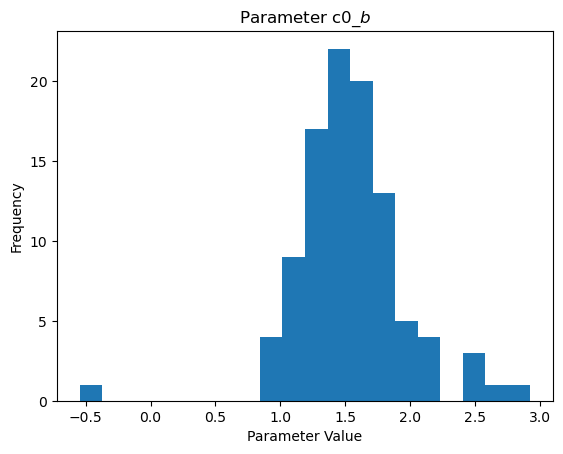

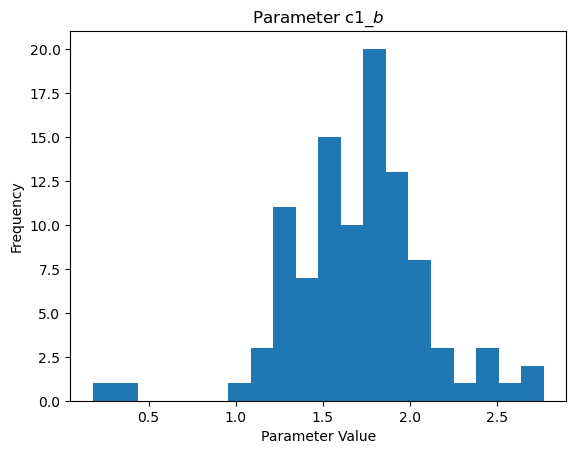

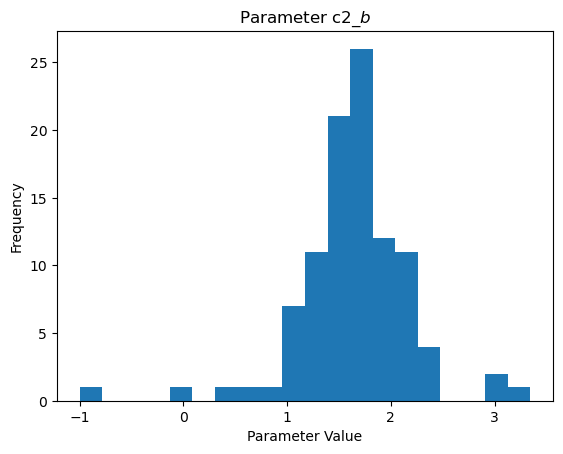

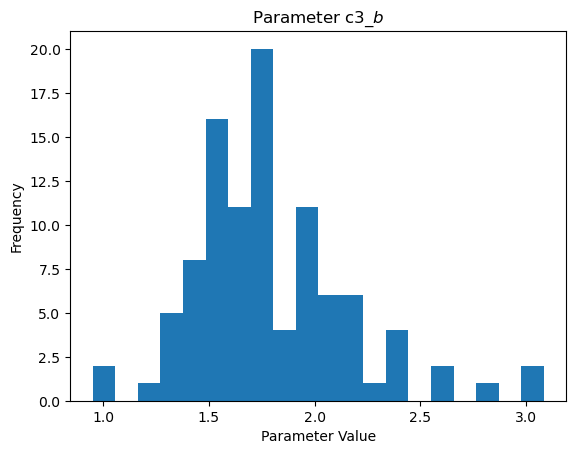

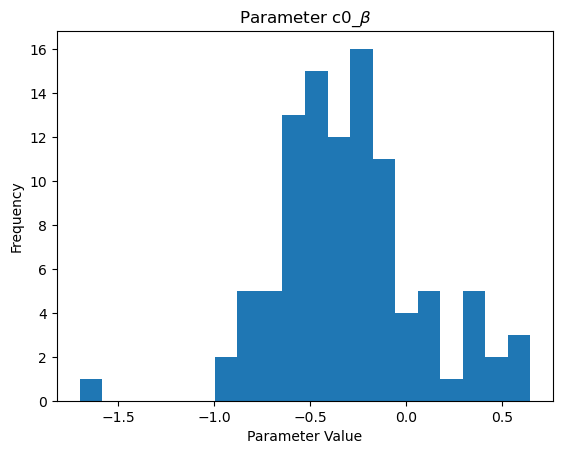

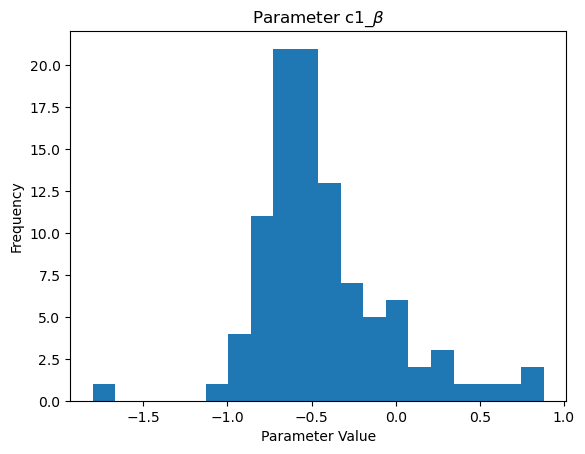

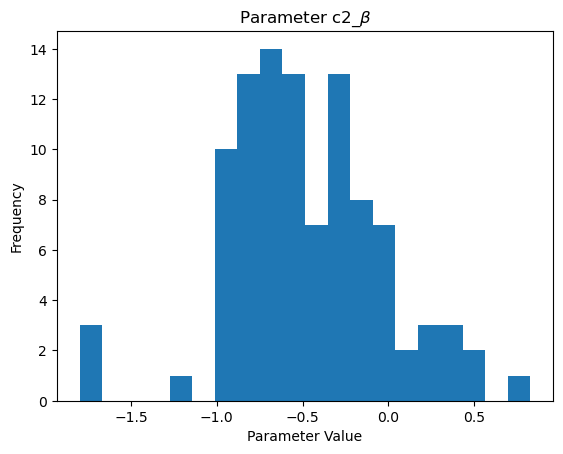

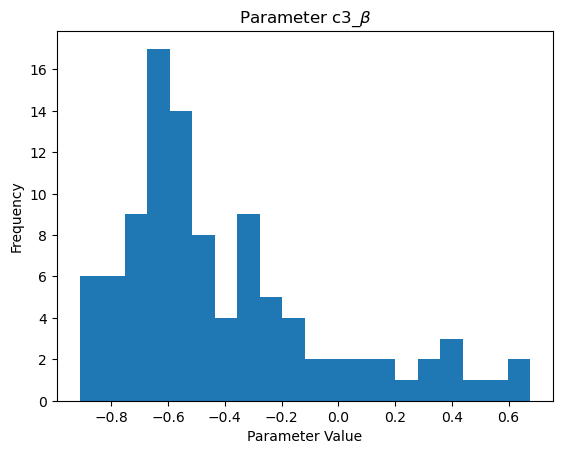

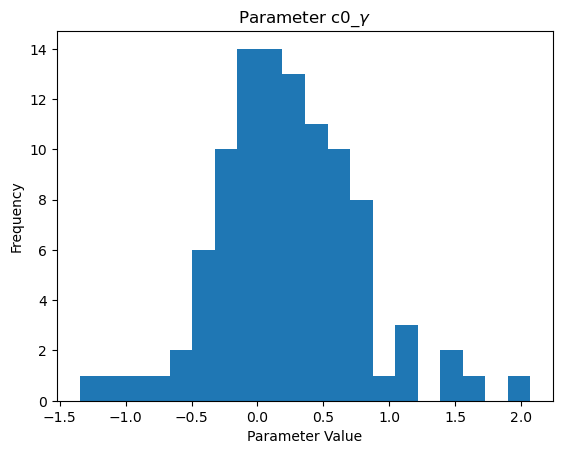

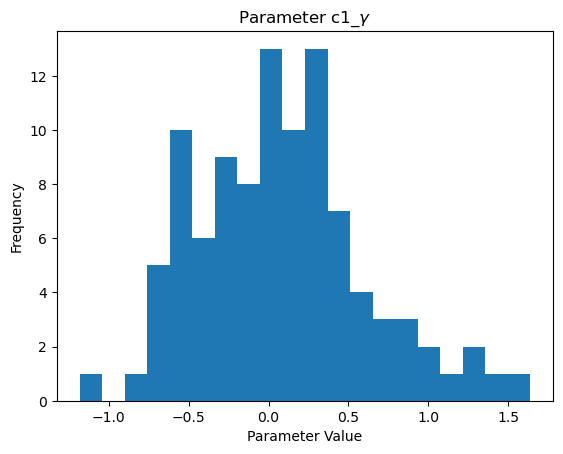

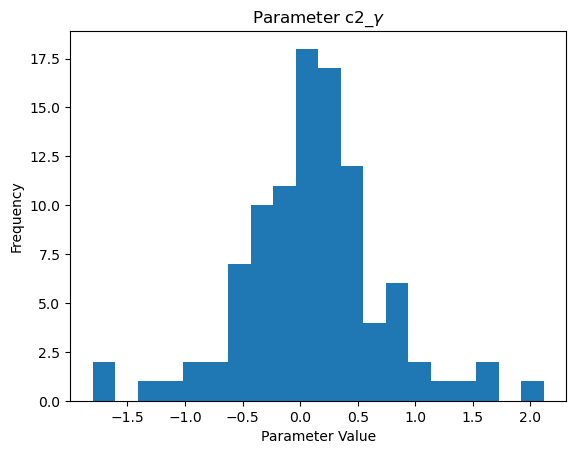

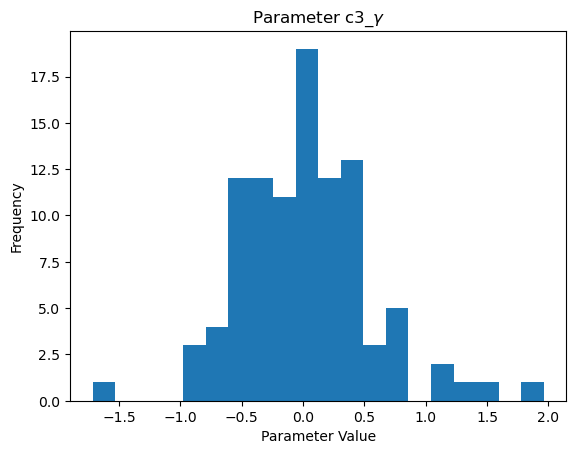

In [24]:
param_names = [i for i in gaba_adata.var.keys() if '$' in i and 'error' not in i]
for name in param_names:
    plt.hist(gaba_adata.var[name], bins=20)
    plt.title('Parameter ' + name)
    plt.xlabel('Parameter Value')
    plt.ylabel('Frequency')
    # plt.savefig(search_result.inference_string + '/parameter_dist_'+ str(i))#'/parameter_dist_{}'.format(
    plt.show()

## Plot parameter values against gene length.

# Analysis

## Reject genes.

In [25]:
# # Add rejection filter to adata.
gaba_adata = inference.reject_genes(gaba_adata, reject_at_bounds=False, mek_means=True, save_csq=True)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)
glu_adata = inference.reject_genes(glu_adata, reject_at_bounds=False, mek_means=True, save_csq=True)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)

# Show rejected genes.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'rejected' in i]])
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'rejected' in i]])

# Show chi-squared values, and other rejection statistics if saved.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'csq' in i or 'pval' in i or 'hellinger' in i]])
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'csq' in i or 'pval' in i or 'hellinger' in i]])

# # # Save chi-square values.
# chi_squareds_glu,  chi_squareds_gaba = glu_adata.var['csq'], gaba_adata.var['csq']

INFO:root:Chi-square computation complete. Rejected 11 genes out of 100. Runtime: 0.2 seconds.
INFO:root:Chi-square computation complete. Rejected 19 genes out of 100. Runtime: 0.2 seconds.
INFO:root:Chi-square computation complete. Rejected 20 genes out of 100. Runtime: 0.2 seconds.
INFO:root:Chi-square computation complete. Rejected 30 genes out of 100. Runtime: 0.2 seconds.
INFO:root:Rejected genes in cluster i have been recorded under "ci_rejected_genes" in .var
INFO:root:Chi-squared values for each gene in cluster i have been added as "ci_csq" in .var
INFO:root:Chi-square computation complete. Rejected 3 genes out of 100. Runtime: 0.4 seconds.
INFO:root:Chi-square computation complete. Rejected 21 genes out of 100. Runtime: 0.4 seconds.
INFO:root:Chi-square computation complete. Rejected 17 genes out of 100. Runtime: 0.5 seconds.
INFO:root:Chi-square computation complete. Rejected 19 genes out of 100. Runtime: 0.4 seconds.
INFO:root:Rejected genes in cluster i have been recorded u

,0_rejected_genes,1_rejected_genes,2_rejected_genes,3_rejected_genes
gene_name,,,,
AC149090.1,False,False,True,True
Map2,False,True,True,True
Eif5b,False,False,False,False
Xrcc5,False,False,False,False
Ptprn,False,True,True,True
...,...,...,...,...
Ptchd1,False,False,False,False
Akap17b,False,False,False,False
Kdm5c,False,False,False,False


,0_rejected_genes,1_rejected_genes,2_rejected_genes,3_rejected_genes
gene_name,,,,
AC149090.1,False,True,True,True
Map2,True,True,True,True
Eif5b,False,False,False,True
Xrcc5,False,False,False,False
Ptprn,False,True,True,True
...,...,...,...,...
Ptchd1,False,False,False,False
Akap17b,False,False,False,False
Kdm5c,False,False,False,True


,0_csq,1_csq,2_csq,3_csq
gene_name,,,,
AC149090.1,54.199328,141.772769,436.289877,217.604957
Map2,214.343853,324.299565,553.835032,332.149001
Eif5b,53.489603,79.748979,136.799586,79.326668
Xrcc5,18.052254,16.895494,58.433476,38.993342
Ptprn,105.064586,211.359379,381.218410,244.889984
...,...,...,...,...
Ptchd1,30.205567,39.161798,48.207398,60.154172
Akap17b,39.495895,57.519948,82.426718,16.810734
Kdm5c,98.060775,66.262783,89.039247,109.238917


,0_csq,1_csq,2_csq,3_csq
gene_name,,,,
AC149090.1,42.355458,43.757438,41.882954,51.332774
Map2,71.781774,81.979774,117.909944,153.437671
Eif5b,10.157793,32.926598,15.063315,41.183657
Xrcc5,3.457769,16.178087,7.093821,2.504894
Ptprn,35.912540,54.051293,58.471791,91.681800
...,...,...,...,...
Ptchd1,5.114968,8.166175,2.872245,4.465852
Akap17b,6.840476,9.338050,0.694736,15.004195
Kdm5c,19.183417,10.932189,17.707804,54.931960


## Execute differential expression analysis.

Clusters: (0, 1)


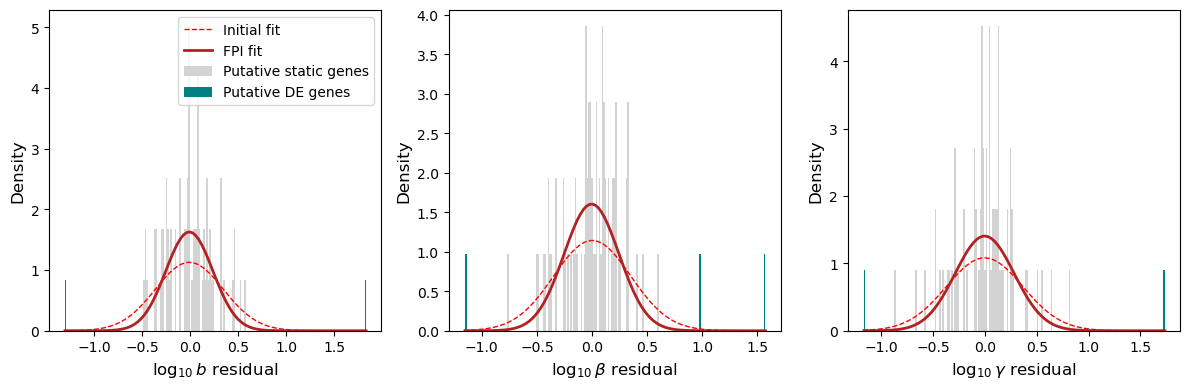

Fold changes between two clusters recorded in .var in form: FC_$\gamma$_(0, 1), where the tuple (i,j) represents the fold change between cluster i and j.
Clusters: (2, 2)


/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:1986: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/cat/monod/src/monod/analysis.py:865: RuntimeWarning: invalid value encountered in divide
  label="Initial fit",
/home/cat/.conda/envs/myenv/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


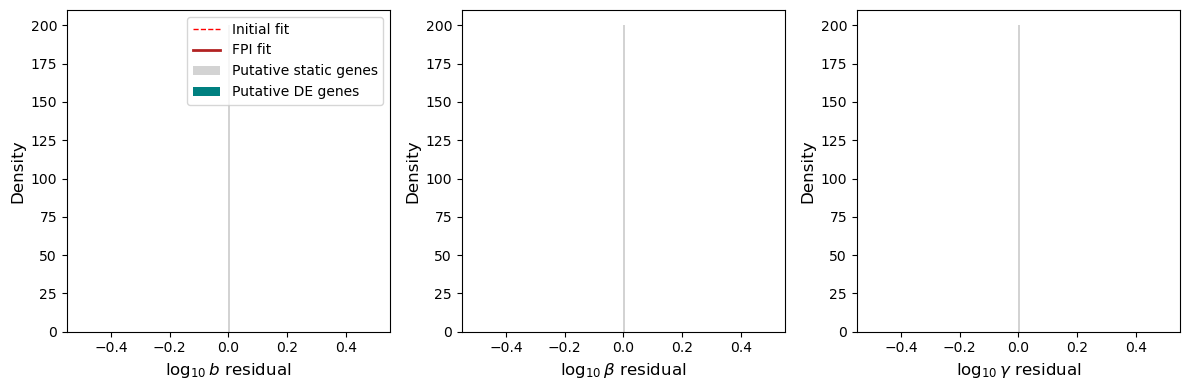

Fold changes between two clusters recorded in .var in form: FC_$\gamma$_(2, 2), where the tuple (i,j) represents the fold change between cluster i and j.
Clusters: (2, 3)


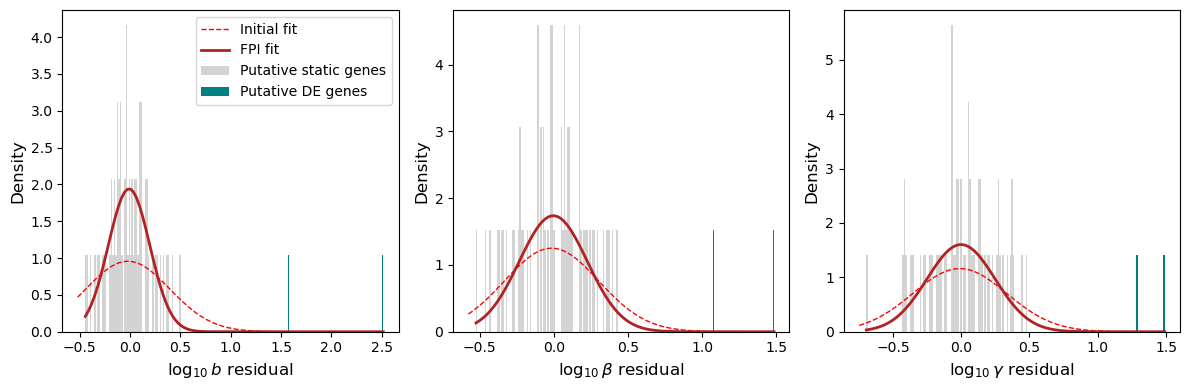

Fold changes between two clusters recorded in .var in form: FC_$\gamma$_(2, 3), where the tuple (i,j) represents the fold change between cluster i and j.
Clusters: (1, 2)


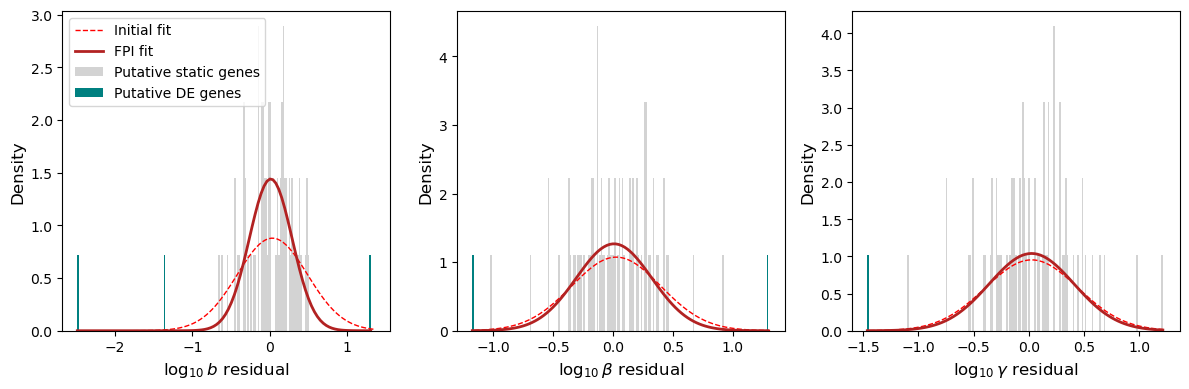

Fold changes between two clusters recorded in .var in form: FC_$\gamma$_(1, 2), where the tuple (i,j) represents the fold change between cluster i and j.
Clusters: (2, 3)


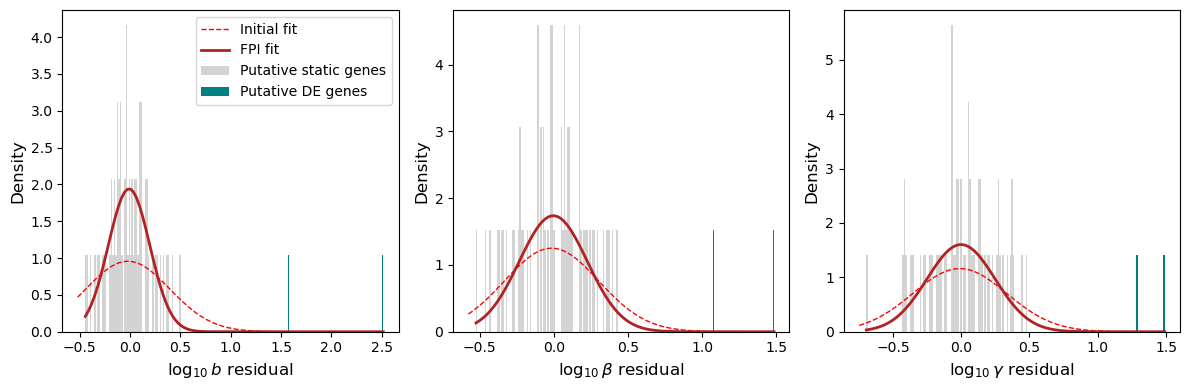

Fold changes between two clusters recorded in .var in form: FC_$\gamma$_(2, 3), where the tuple (i,j) represents the fold change between cluster i and j.
Clusters: (2, 3)


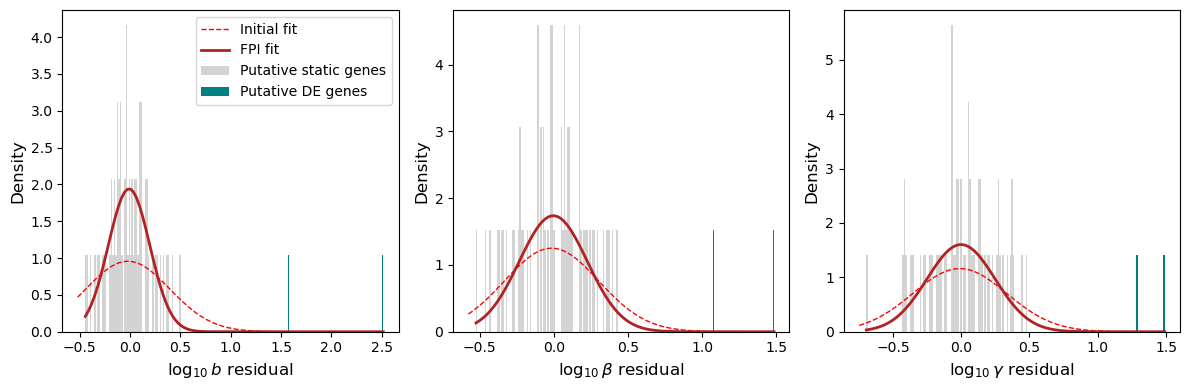

Fold changes between two clusters recorded in .var in form: FC_$\gamma$_(2, 3), where the tuple (i,j) represents the fold change between cluster i and j.


E.g.$\log_{10} b$

(0, 1) Index(['Plekha8', 'Ccdc82'], dtype='object', name='gene_name')


,"FC_$b$_(0, 1)","FC_$\beta$_(0, 1)","FC_$\gamma$_(0, 1)","FC_$b$_(2, 2)","FC_$\beta$_(2, 2)","FC_$\gamma$_(2, 2)","FC_$b$_(2, 3)","FC_$\beta$_(2, 3)","FC_$\gamma$_(2, 3)","FC_$b$_(1, 2)","FC_$\beta$_(1, 2)","FC_$\gamma$_(1, 2)"
gene_name,,,,,,,,,,,,
AC149090.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Map2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Eif5b,0.273537,-0.094541,-0.098441,0.0,0.0,0.0,NaN,NaN,NaN,-0.185197,-0.208602,-0.024044
Xrcc5,0.767903,0.054625,-0.157517,0.0,0.0,0.0,0.133341,-0.077529,-0.179928,-0.410650,0.181714,0.337375
Ptprn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
Ptchd1,0.094464,-0.403740,-0.467310,0.0,0.0,0.0,-0.042434,-0.215280,-0.457558,0.046533,0.311416,0.383973
Akap17b,0.268378,-0.190594,-0.173837,0.0,0.0,0.0,-0.318425,-0.470053,-0.603104,0.075917,0.249412,0.335256
Kdm5c,0.222033,-0.070293,-0.041253,0.0,0.0,0.0,NaN,NaN,NaN,-0.160331,-0.101486,0.000422


In [37]:
# If 2 anndata objects are given, parameters are compared across datasets.
if not mek_means_params:
    DE_genes, DE_filter, offs, residuals = analysis.DE_parameters(glu_adata, gaba_adata,
                                                              viz=True, use_sigma=True)

# If using meK-Means, compare clusters within one dataset.
else:
    DE_genes_gaba, DE_filter_gaba, offs_gaba, residuals_gaba = analysis.DE_parameters(gaba_adata,
                                                              viz=True, use_sigma=True, discard_rejected=True,
                                                                                     save_cluster_FCs=True)
    clusters = [i for i in DE_genes_gaba.keys()]
    DE_genes = [DE_genes_gaba[i] for i in clusters]
    param_names = gaba_adata.uns['search_result_list'][0].model.get_log_name_str()
    param_num, cluster_num = 0,0
    display(Markdown('E.g.' + param_names[param_num]))
    print(clusters[cluster_num], DE_genes[cluster_num][param_num])

display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'FC' in i]])

In [ ]:
# # NB changing loom to h5ad.
# adata_gaba = anndata.read_loom('monod_examples/sample_data/allen_C01_gaba.loom')
# adata_gaba.var_names = adata_gaba.var['gene_name']
# adata_gaba.obs_names = adata_gaba.obs['barcode']
# adata_gaba.obs = adata_gaba.obs.drop(columns=['barcode'])
# adata_gaba.var = adata_gaba.var.drop(columns=['gene_name'])
# adata_gaba.write('gaba_example.h5ad')

### Show some gene distributions.

Cluster: 0
AC149090.1
Map2
Eif5b


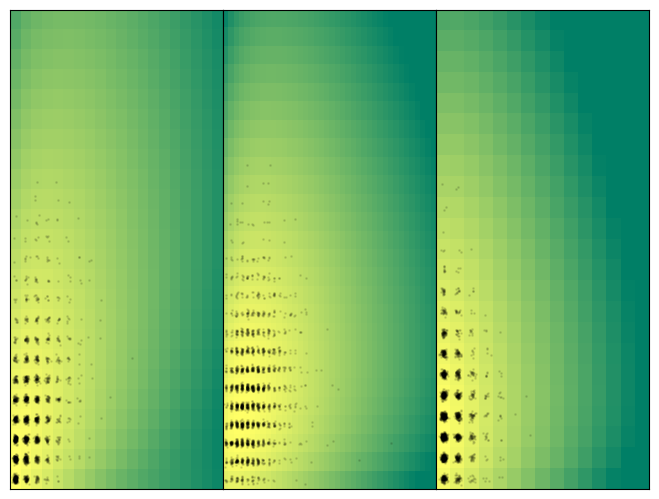

In [27]:
fitted_adata = glu_adata

if not mek_means_params:
    search_result, search_data = fitted_adata.uns['search_result'], fitted_adata.uns['search_data']
else:
    cluster_num = 0
    search_result = fitted_adata.uns['search_result_list'][cluster_num]
    search_data = fitted_adata.uns['search_data']
    search_data  =  search_result._subset_search_data(search_data)
    print('Cluster:', cluster_num)
    
logscale = True

sz =(1,3)
(nrows, ncols) = sz
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols)

nax = np.prod(sz)

genes_to_plot = np.arange(nax)

genes_to_plot = np.asarray(genes_to_plot)
if genes_to_plot.dtype == bool:
    gtp_temp = np.arange(self.n_genes)
    genes_to_plot = gtp_temp[genes_to_plot]

number_of_genes_to_plot = len(genes_to_plot)
if number_of_genes_to_plot > 5:
    number_of_genes_to_plot = 5
    genes_to_plot = genes_to_plot[: 5]
if number_of_genes_to_plot > nax:  # This should no longer break...
    number_of_genes_to_plot = nax
    genes_to_plot = genes_to_plot[:nax]

j_ = 0
marg = 'joint'
modalities = ['spliced', 'unspliced']

for i_ in genes_to_plot:
    lm = np.copy(search_data.M[:, i_])

    # TODO: generalize by adding attribute names as attribute of e.g. CMEModel
    # attributes = ['unspliced', 'spliced', 'protein']

    num_modalities = 2
    for i in range(num_modalities):
        if marg == modalities[i]:
            lm[:i] = 1
            lm[i+1:]=1

    axloc = np.unravel_index(j_, sz) if (sz[0] > 1 and sz[1] > 1) else j_

    samp = search_result.regressor_optimum[i_]
    Pa = np.squeeze(search_result.model.eval_model_pss(search_result.phys_optimum[i_], lm, samp))
    layers = np.array([i.copy() for i in search_data.layers])

    marg = 'joint'
    if marg == "joint":
        if logscale:
            Pa[Pa < 1e-10] = 1e-10
            Pa = np.log10(Pa)

        if num_modalities==2:
            ax1[axloc].imshow(Pa.T, aspect="auto", cmap="summer")
        elif num_modalities==3:
            ax1[axloc].imshow(Pa.sum(axis=2).T, aspect="auto", cmap="summer")
        else:
            log.error('Joint distribution plot only implemented for 2 or 3 modalities')

        ax1[axloc].invert_yaxis()

        jitter_magn = 0.1
        jitter = np.random.randn(2, search_result.n_cells) * jitter_magn
        ax1[axloc].scatter(
            *layers[:2, :,i_] + jitter, c="k", s=1, alpha=0.1
        )

        ax1[axloc].set_xlim([-0.5, search_data.M[0, i_] - 1.5])
        ax1[axloc].set_ylim([-0.5, search_data.M[1, i_] - 1.5])
    else:
        plot_hist_and_fit(ax1[axloc], search_data, i_, Pa, marg)
        if logscale:
            ax1[axloc].set_yscale("log")

    print(search_result.gene_names[i_])
    # if title:
    #     titlestr = search_result.gene_names[i_]
    #     if hasattr(search_result, "rejected_genes") and search_result.rejected_genes[i_]:
    #         titlestr += " (rej.)"
    #     ax1[axloc].set_title(titlestr, fontdict={"fontsize": 9})
    ax1[axloc].set_xticks([])
    ax1[axloc].set_yticks([])
    j_ += 1
fig1.tight_layout(pad=0.02)


/home/cat/monod/src/monod/mminference.py:1684: RuntimeWarning: divide by zero encountered in divide
  dx = (np.asarray(self.sp.samp_ub) - np.asarray(self.sp.samp_lb)) / (
/home/cat/monod/src/monod/mminference.py:1694: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  lnd = ax.imshow(


INFO:root:Figure stored to new_gaba__/Bursty_Poisson_1x1/analysis_figures_0/kldiv.png.
INFO:root:Figure stored to new_gaba__/Bursty_Poisson_1x1/analysis_figures_0/gene_distributions_joint.png.
INFO:root:Chi-square computation complete. Rejected 78 genes out of 100. Runtime: 0.3 seconds.
INFO:root:Figure stored to new_gaba__/Bursty_Poisson_1x1/analysis_figures_0/subsampling.png.
INFO:root:Figure stored to new_gaba__/Bursty_Poisson_1x1/analysis_figures_0/subsampling_stability.png.
INFO:root:Original optimum: -6.80, -1.50.
INFO:root:Chi-square computation complete. Rejected 11 genes out of 100. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.80, -1.50.
INFO:root:Chi-square computation complete. Rejected 11 genes out of 100. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.80, -1.50.
INFO:root:Chi-square computation complete. Rejected 11 genes out of 100. Runtime: 0.2 seconds.
INFO:root:New optimum: -6.80, -1.50.
INFO:root:Chi-square computation complete. Rejected 11 genes out of 100. Runti

/home/cat/monod/src/monod/mminference.py:2144: RuntimeWarning: invalid value encountered in sqrt
  sigma[gene_index, :] = np.sqrt(np.diag(hess_inv)) / np.sqrt(


INFO:root:Figure stored to new_gaba__/Bursty_Poisson_1x1/analysis_figures_0/length_dependence.png.
INFO:root:Figure stored to new_gaba__/Bursty_Poisson_1x1/analysis_figures_0/parameter_marginals.png.
ERROR:root:Updated results could not be stored to new_gaba__/Bursty_Poisson_1x1/grid_scan_results_0_upd.res.


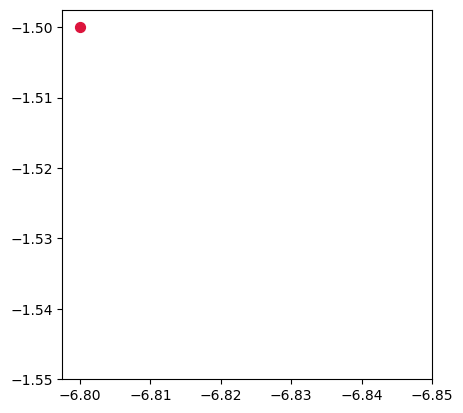

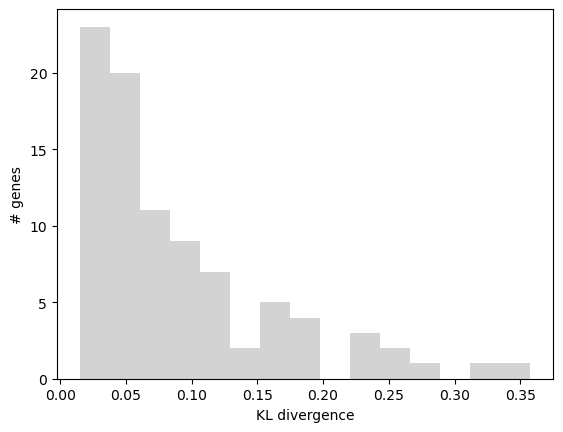

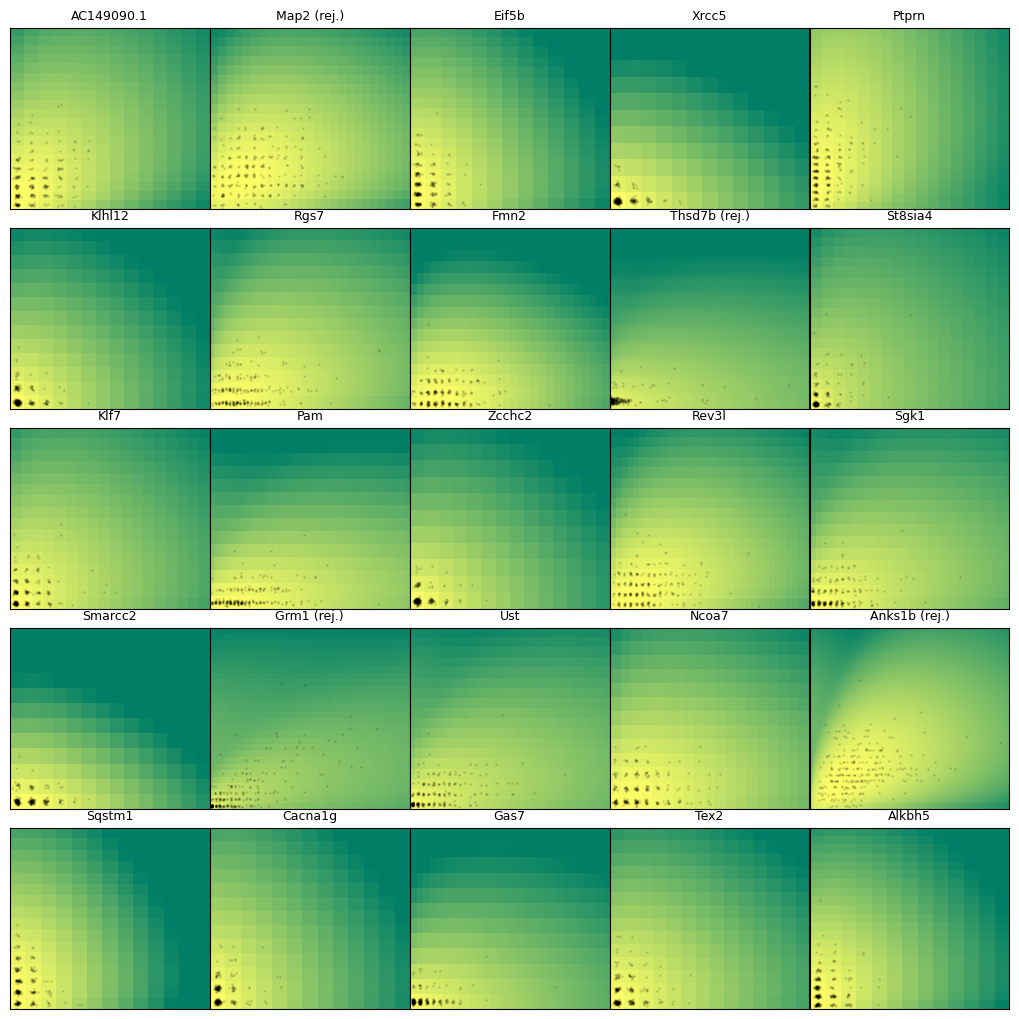

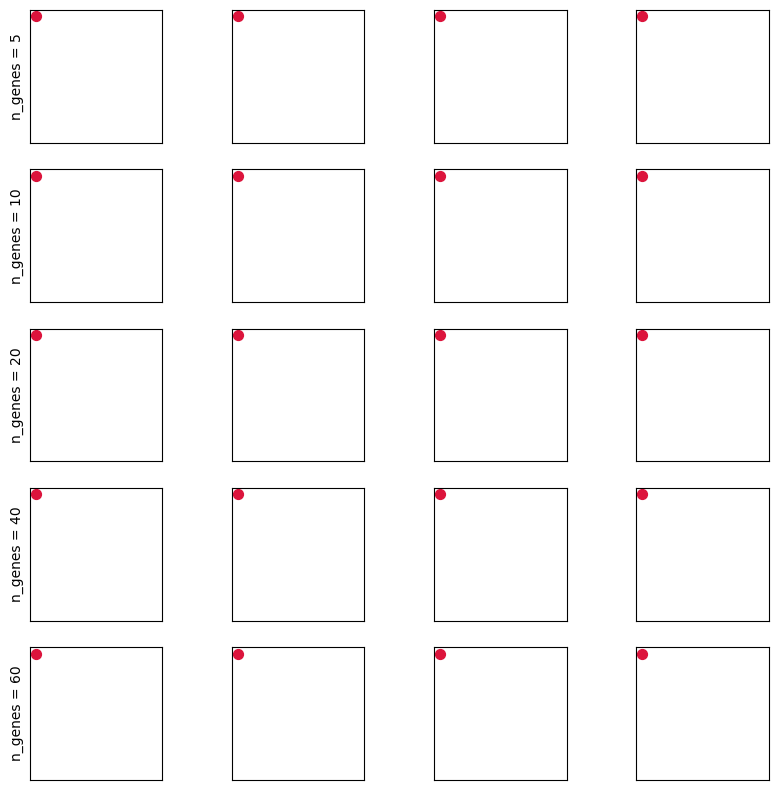

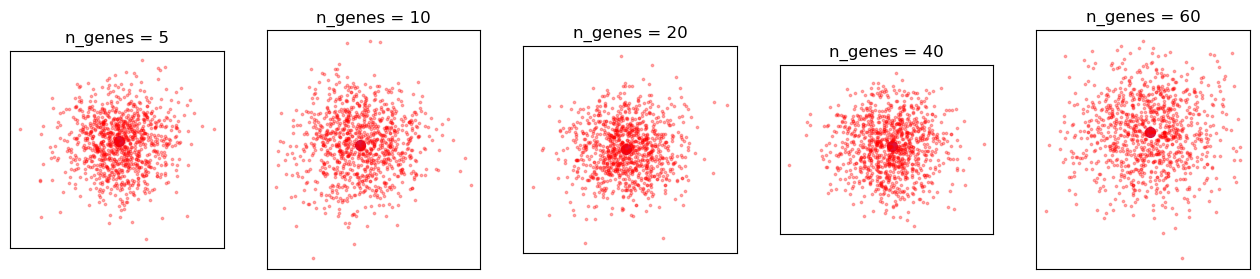

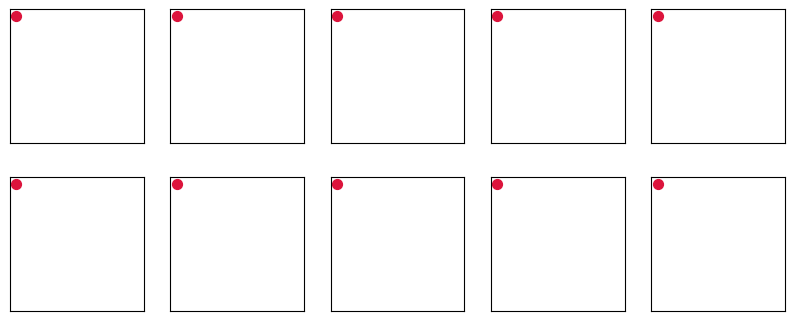

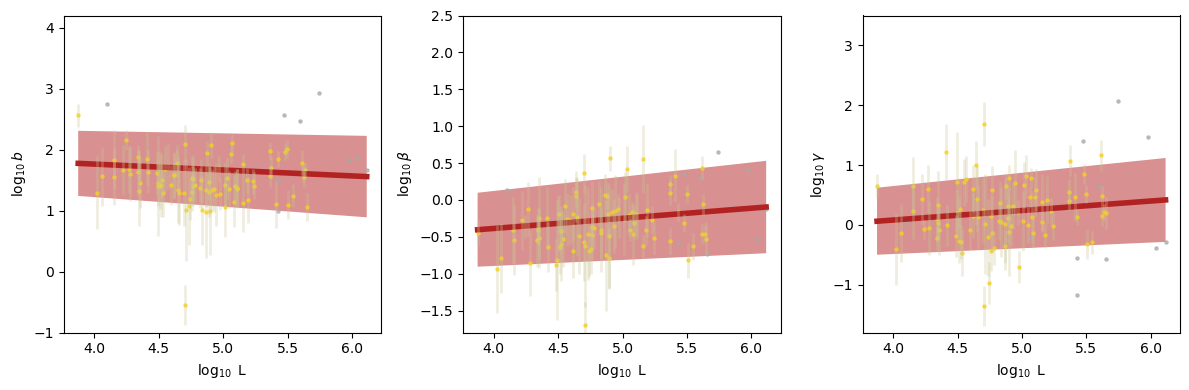

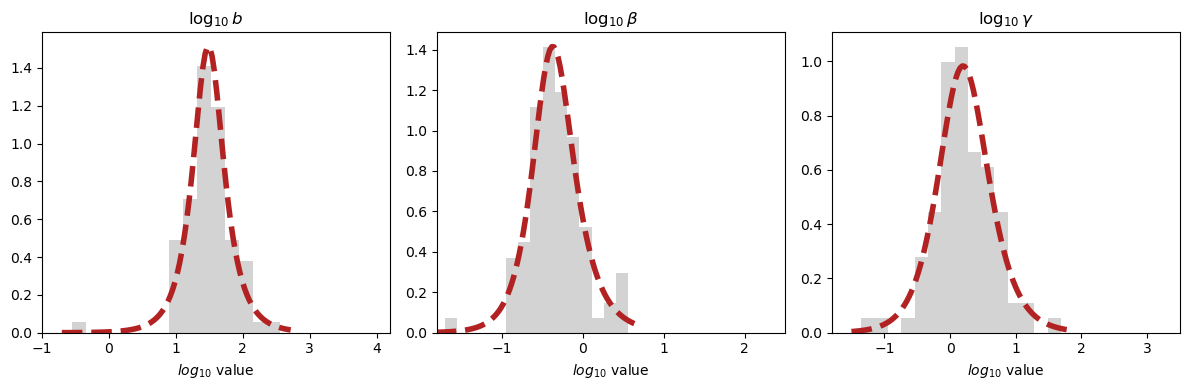

In [36]:
analysis.run_qc(gaba_adata, mek_means_params=mek_means_params)